#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to ML Fairness
***

## Disclaimer
This exercise explores just a small subset of  ideas and techniques relevant to fairness in machine learning; it is not the whole story!

## Learning Objectives

* Increase awareness of different types of biases that can manifest in model data.
* Explore feature data to proactively identify potential sources of bias before training a model
* Evaluate model performace by subgroup rather than in aggregate

## Overview

In this exercise, you'll explore datasets and evaluate classifiers with *fairness* in mind, noting the ways undesirable biases can creep into machine learning (ML).

Throughout, you will see **FairAware** tasks, which provide opportunities to contextualize ML processes with respect to fairness. In performing these tasks, you'll identify biases and consider the long-term impact of model predictions if these biases are not addressed.

## About the Dataset and Prediction Task

In this exercise, you'll work with the [Adult Census Income dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income), which is commonly used in machine learning literature. This data was extracted from the [1994 Census bureau database](http://www.census.gov/en.html) by Ronny Kohavi and Barry Becker.

Each example in the dataset contains the following demographic data for a set of individuals who took part in the 1994 Census:

### Numeric Features
*   `age`: The age of the individual in years.
*   `fnlwgt`: The number of individuals the Census Organizations believes that set of observations represents.
*   `education_num`:  An enumeration of the categorical representation of education. The higher the number, the higher the education that individual achieved. For example, an `education_num` of `11` represents `Assoc_voc` (associate degree at a vocational school), an `education_num` of `13` represents `Bachelors`, and an `education_num` of `9` represents `HS-grad` (high school graduate).
*   `capital_gain`: Capital gain made by the individual, represented in US Dollars.
*   `capital_loss`: Capital loss mabe by the individual, represented in US Dollars.
*   `hours_per_week`: Hours worked per week.

### Categorical Features
*   `workclass`: The individual's type of employer. Examples include: `Private`, `Self-emp-not-inc`, `Self-emp-inc`, `Federal-gov`, `Local-gov`, `State-gov`, `Without-pay`, and `Never-worked`.
*   `education`: The highest level of education achieved for that individual.
*   `marital_status`: Marital status of the individual. Examples include: `Married-civ-spouse`, `Divorced`, `Never-married`, `Separated`, `Widowed`, `Married-spouse-absent`, and `Married-AF-spouse`.
*   `occupation`: The occupation of the individual. Example include: `tech-support`, `Craft-repair`, `Other-service`, `Sales`, `Exec-managerial` and more.
*   `relationship`:  The relationship of each individual in a household. Examples include: `Wife`, `Own-child`, `Husband`, `Not-in-family`, `Other-relative`, and `Unmarried`.
*   `gender`:  Gender of the individual available only in binary choices: `Female` or `Male`.
*   `race`: `White`, `Asian-Pac-Islander`, `Amer-Indian-Eskimo`, `Black`, and `Other`. 
*   `native_country`: Country of origin of the individual. Examples include: `United-States`, `Cambodia`, `England`, `Puerto-Rico`, `Canada`, `Germany`, `Outlying-US(Guam-USVI-etc)`, `India`, `Japan`, `United-States`, `Cambodia`, `England`, `Puerto-Rico`, `Canada`, `Germany`, `Outlying-US(Guam-USVI-etc)`, `India`, `Japan`, and more.

### Prediction Task
The prediction task is to **determine whether a person makes over $50,000 US Dollar a year.**

### Label
*   `income_bracket`: Whether the person makes more than $50,000 US Dollars annually.

### Notes on Data Collection

All the examples extracted for this dataset meet the following conditions: 
*   `age` is 16 years or older.
*   The adjusted gross income (used to calculate `income_bracket`) is greater than $100 USD annually.
*   `fnlwgt` is greater than 0.
*   `hours_per_week` is greater than 0.






## Setup

First, import some modules that will be used throughout this notebook.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tempfile
!pip install seaborn==0.8.1
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from google.colab import widgets
# For facets
from IPython.core.display import display, HTML
import base64
!pip install -q hopsfacets 
import hopsfacets as facets
from hopsfacets.feature_statistics_generator import FeatureStatisticsGenerator

print('Modules are imported.')

    100% |████████████████████████████████| 184kB 10.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/26/0a/44/53ddd89769e62f7c6691976375b86c6492e7dd20a2d3970e32
Successfully built seaborn
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.1.post2 which is incompatible.
  Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
Modules are imported.


### Load the Adult Dataset

With the modules now imported, we can load the Adult dataset into a pandas DataFrame data structure.

In [3]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

train_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=COLUMNS,
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")
test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=COLUMNS,
    sep=r'\s*,\s*',
    skiprows=[0],
    engine='python',
    na_values="?")

# Drop rows with missing values
train_df = train_df.dropna(how="any", axis=0)
test_df = test_df.dropna(how="any", axis=0)

print('UCI Adult Census Income dataset loaded.')

UCI Adult Census Income dataset loaded.


## Analyzing the Adult Dataset with Facets

As mentioned in MLCC, it is important to understand your dataset *before* diving straight into the prediction task. 

Some important questions to investigate when auditing a dataset for fairness:

* **Are there missing feature values for a large number of observations?**
* **Are there features that are missing that might affect other features?**
* **Are there any unexpected feature values?**
* **What signs of data skew do you see?**

To start, we can use [Facets Overview](https://pair-code.github.io/facets/), an interactive visualization tool that can help us explore the dataset. With Facets Overview, we can quickly analyze the distribution of values across the Adult dataset.

In [4]:
#@title Visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

### FairAware Task #1

Review the descriptive statistics and histograms for each numerical and continuous feature. Click the **Show Raw Data** button above the histograms for categorical features to see the distribution of values per category.

Then, try to answer the following questions from earlier:

1. Are there missing feature values for a large number of observations?
2. Are there features that are missing that might affect other features?
3. Are there any unexpected feature values?
4. What signs of data skew do you see?

### Solution

Click below for some insights we uncovered.

We can see from reviewing the **missing** columns for both numeric and categorical features that there are no missing feature values, so that is not a concern here. 

By looking at the min/max values and histograms for each numeric feature, we can pinpoint any extreme outliers in our data set. For `hours_per_week`, we can see that the minimum is 1, which might be a bit surprising, given that most jobs typically require multiple hours of work per week. For `capital_gain` and `capital_loss`, we can see that over 90% of values are 0. Given that capital gains/losses are only registered by individuals who make investments, it's certainly plausible that less than 10% of examples would have nonzero values for these feature, but we may want to take a closer look to verify the values for these features are valid.

In looking at the histogram for gender, we see that over two-thirds (approximately 67%) of examples represent males. This strongly suggests data skew, as we would expect the breakdown between genders to be closer to 50/50.

### A Deeper Dive

To futher explore the dataset, we can use [Facets Dive](https://pair-code.github.io/facets/), a tool that provides an interactive interface where each individual item in the visualization represents a data point. But to use Facets Dive, we need to convert our data to a JSON array.
Thankfully the DataFrame method `to_json()` takes care of this for us.

Run the cell below to perform the data transform to JSON and also load Facets Dive. 

In [5]:
#@title Set the Number of Data Points to Visualize in Facets Dive

SAMPLE_SIZE = 2500 #@param
  
train_dive = train_df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=train_dive)
display(HTML(html))

## FairAware Task #2

Use the menus on the left panel of the visualization to change how the data is organized:

1. In the **Faceting | X-Axis** menu, select **education**, and in the **Display | Color** and  **Display | Type** menus, select **income_bracket**. How would you describe the relationship between education level and income bracket?

2. Next, in the **Faceting | X-Axis** menu, select  **marital_status**, and in the **Display | Color** and  **Display | Type** menus, select **gender**. What noteworthy observations can you make about the gender distributions for each marital-status category?

As you perform the above tasks, keep the following fairness-related questions in mind:

*  **What's missing?**
* **What's being overgeneralized?**
* **What's being underrepresented?**
* **How do the variables, and their values, reflect the real world?**
* **What might we be leaving out?**

### Solution

Click below for some insights we uncovered.

1. In our data set, higher education levels generally tend to correlate with a higher income bracket. An income level of greater than $50,000 is more heavily represented in examples where education level is Bachelor's degree or higher.

2. In most marital-status categories, the distribution of male vs. female values is close to 1:1. The one notable exception is "married-civ-spouse", where male outnumbers female by more than 5:1. Given that we already discovered in Task #1 that there is a disproportionately high representation of men in our data set, we can now infer that it's married women specifically that are underrepresented in our data.

### Summary

Plotting histograms, ranking most-to-least common examples, identifying duplicate or missing examples, making sure the training and test sets are similar, computing feature quantiles—**these are all critical analyses to perform on your data.** 

**The better you know what's going on in your data, the more insight you'll have as to where unfairness might creep in!**

### FairAware Task #3

Now that you've explored the dataset using Facets, see if you can identify some of the problems that may arise with regard to fairness based on what you've learned about its features.

Which of the following features might pose a problem with regard to fairness?

Choose a feature from the drop-down options in the cell below, and then run the cell to check your answer. Then explore the rest of the options to get more insight about how each influences the model's predictions.

In [6]:
feature = 'capital_gain / capital_loss' #@param ["", "hours_per_week", "fnlwgt", "gender", "capital_gain / capital_loss", "age"] {allow-input: false}


if feature == "hours_per_week":
  print(
'''It does seem a little strange to see 'hours_per_week' max out at 99 hours,
which could lead to data misrepresentation. One way to address this is by
representing 'hours_per_week' as a binary "working 40 hours/not working 40
hours" feature. Also keep in mind that data was extracted based on work hours
being greater than 0. In other words, this feature representation exclude a
subpopulation of the US that is not working. This could skew the outcomes of the
model.''')
if feature == "fnlwgt":
  print(
"""'fnlwgt' represents the weight of the observations. After fitting the model
to this data set, if certain group of individuals end up performing poorly 
compared to other groups, then we could explore ways of reweighting each data 
point using this feature.""")
if feature == "gender":
  print(
"""Looking at the ratio between men and women shows how disproportionate the data
is compared to the real world where the ratio (at least in the US) is closer to
1:1. This could pose a huge probem in performance across gender. Considerable
measures may need to be taken to upsample the underrepresented group (in this
case, women).""")
if feature == "capital_gain / capital_loss":
  print(
"""Both 'capital_gain' and 'capital_loss' have very low variance, which might
suggest they don't contribute a whole lot of information for predicting income. It
may be okay to omit these features rather than giving the model more noise.""")
if feature == "age":
  print(
'''"age" has a lot of variance, so it might benefit from bucketing to learn
fine-grained correlations between income and age, as well as to prevent
overfitting.''')


Both 'capital_gain' and 'capital_loss' have very low variance, which might
suggest they don't contribute a whole lot of information for predicting income. It
may be okay to omit these features rather than giving the model more noise.


## Prediction Using TensorFlow Estimators

Now that we have a better sense of the Adult dataset, we can now begin with creating a neural network to predict income. In this section, we will be using TensorFlow's Estimator API to access the `DNNClassifier` class

### Convert Adult Dataset into Tensors
We first have to define our input fuction, which will take the Adult dataset that is in a pandas DataFrame and converts it into tensors using the ```tf.estimator.inputs.pandas_input_fn()``` function.

In [7]:
def csv_to_pandas_input_fn(data, batch_size=100, num_epochs=1, shuffle=False):
  return tf.estimator.inputs.pandas_input_fn(
      x=data.drop('income_bracket', axis=1),
      y=data['income_bracket'].apply(lambda x: ">50K" in x).astype(int),
      batch_size=batch_size,
      num_epochs=num_epochs,
      shuffle=shuffle,
      num_threads=1)

print 'csv_to_pandas_input_fn() defined.'

csv_to_pandas_input_fn() defined.


### Represent Features in TensorFlow
TensorFlow requires that data maps to a model. To accomplish this, you have to use ```tf.feature_columns``` to ingest and represent features in TensorFlow.

In [8]:
#@title Categorical Feature Columns

# Since we don't know the full range of possible values with occupation and
# native_country, we'll use categorical_column_with_hash_bucket() to help map
# each feature string into an integer ID.
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    "occupation", hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket(
    "native_country", hash_bucket_size=1000)

# For the remaining categorical features, since we know what the possible values
# are, we can be more explicit and use categorical_column_with_vocabulary_list()
gender = tf.feature_column.categorical_column_with_vocabulary_list(
    "gender", ["Female", "Male"])
race = tf.feature_column.categorical_column_with_vocabulary_list(
    "race", [
        "White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"
    ])
education = tf.feature_column.categorical_column_with_vocabulary_list(
    "education", [
        "Bachelors", "HS-grad", "11th", "Masters", "9th",
        "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
        "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
        "Preschool", "12th"
    ])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    "marital_status", [
        "Married-civ-spouse", "Divorced", "Married-spouse-absent",
        "Never-married", "Separated", "Married-AF-spouse", "Widowed"
    ])
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    "relationship", [
        "Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
        "Other-relative"
    ])
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    "workclass", [
        "Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
        "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"
    ])

print 'Categorical feature columns defined.'

Categorical feature columns defined.


In [9]:
#@title Numeric Feature Columns
# For Numeric features, we can just call on feature_column.numeric_column()
# to use its raw value instead of having to create a map between value and ID.
age = tf.feature_column.numeric_column("age")
fnlwgt = tf.feature_column.numeric_column("fnlwgt")
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")

print 'Numeric feature columns defined.'

Numeric feature columns defined.


#### Make Age a Categorical Feature

If you chose `age` when completing **FairAware Task #3**, you noticed that we suggested that `age` might benefit from *bucketing* (also known as *binning*), grouping together similar ages into different groups. This might help the model generalize better across age. As such, we will convert `age` from a numeric feature (technically, an [ordinal feature](https://en.wikipedia.org/wiki/Ordinal_data)) to a categorical feature.

In [0]:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

#### Consider Key Subgroups

When performing feature engineering, it's important to keep in mind that you may be working with data drawn from individuals belonging to subgroups, for which you'll want to evaluate model performance separately.

**_NOTE:_** *In this context, a subgroup is defined as a group of individuals who share a given characteristic—such as race, gender, or sexual orientation—that merits special consideration when evaluating a model with fairness in mind.*

When we want our models to mitigate, or leverage, the learned signal of a characteristic pertaining to a subgroup, we will want to use different kinds of tools and techniques—**most of which are still open research at this point**.

As you work with different variables and define tasks for them, it can be useful to think about what comes next. For example, *where are the places where the interaction of the variable and the task could be a concern?*

### Define the Model Features

Now we can explicitly define which feature we will include in our model.

We'll consider `gender` a subgroup and save it in a separate `subgroup_variables` list, so we can add special handling for it as needed.

In [0]:
# List of variables, with special handling for gender subgroup.
variables = [native_country, education, occupation, workclass,
             relationship, age_buckets]
subgroup_variables = [gender]
feature_columns = variables + subgroup_variables

### Train a Deep Neural Net Model on Adult Dataset

With the features now ready to go, we can try predicting income using deep learning.

For the sake of simplicity, we are going to keep the neural network architecture light by simply **defining a feed-forward neural network with two hidden layers**.

But first, we have to convert our high-dimensional categorical features into a low-dimensional and dense real-valued vector, which we call an embedding vector. Luckily, ```indicator_column``` (think of it as one-hot encoding) and ```embedding_column``` (that converts sparse features into dense features) helps us streamline the process.

The following cell creates the deep columns needed to move forward with defining the model.

In [12]:
deep_columns = [
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(age_buckets),
    tf.feature_column.indicator_column(gender),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.embedding_column(native_country, dimension=8),
    tf.feature_column.embedding_column(occupation, dimension=8),
]

print deep_columns
print 'Deep columns created.'

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='workclass', vocabulary_list=('Self-emp-not-inc', 'Private', 'State-gov', 'Federal-gov', 'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='education', vocabulary_list=('Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65))), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='gender', vocabulary_list=('Female', 'Male'), dtype=tf.string, default_value=-1, num_oov

With all our data preprocessing taken care of, we can now define the deep neural net model. Start by using the parameters defined below. (Later on, after you've defined evaluation metrics and evaluated the model, you can come back and tweak these parameters to compare results.)



In [13]:
#@title Define Deep Neural Net Model

HIDDEN_UNITS = [1024, 512] #@param
LEARNING_RATE = 0.1 #@param
L1_REGULARIZATION_STRENGTH = 0.0001 #@param
L2_REGULARIZATION_STRENGTH = 0.0001 #@param

model_dir = tempfile.mkdtemp()
single_task_deep_model = tf.estimator.DNNClassifier(
    feature_columns=deep_columns,
    hidden_units=HIDDEN_UNITS,
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=LEARNING_RATE,
      l1_regularization_strength=L1_REGULARIZATION_STRENGTH,
      l2_regularization_strength=L2_REGULARIZATION_STRENGTH),
    model_dir=model_dir)

print 'Deep neural net model defined.'

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd020ae0b50>, '_model_dir': '/tmp/tmpXTc0YY', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
Deep neural net model defined.


To keep things simple, we will train for 1000 steps—but feel free to play around with this parameter.

In [14]:
#@title Fit Deep Neural Net Model to the Adult Training Dataset

STEPS = 1000 #@param

single_task_deep_model.train(
    input_fn=csv_to_pandas_input_fn(train_df, num_epochs=None, shuffle=True),
    steps=STEPS);

print "Deep neural net model is done fitting."

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:

We can now evalute the overall model's performance using the held-out test set.

In [15]:
#@title Evaluate Deep Neural Net Performance

results = single_task_deep_model.evaluate(
    input_fn=csv_to_pandas_input_fn(test_df, num_epochs=1, shuffle=False),
    steps=None)
print("model directory = %s" % model_dir)
print("---- Results ----")
for key in sorted(results):
  print("%s: %s" % (key, results[key]))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-24T16:01:55Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpXTc0YY/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-24-16:01:57
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8330677, accuracy_baseline = 0.7543161, auc = 0.8845753, auc_precision_recall = 0.7058527, average_loss = 0.3601637, global_step = 1000, label/mean = 0.24568394, loss = 35.92096, precision = 0.71962965, prediction/mean = 0.22734155, recall = 0.52513516
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpXTc0YY/model.ckpt-1000
model directory = /tmp/tmpXTc0YY

You can try retraining the model using different parameters. In the end, you will find that  a deep neural net does a decent job in predicting income. 

**But what is missing here is evaluation metrics with respect to subgroups.** We will cover some of the ways you can evaluate at the subgroup level in the next section.

## Evaluating for Fairness Using a Confusion Matrix

While evaluating the overall performance of the model gives us some insight into its quality, it doesn't give us much insight into how well our model performs for different subgroups.  

When evaluating a model for fairness, it's important to determine whether prediction errors are uniform across subgroups or whether certain subgroups are more susceptible to certain prediction errors than others. 

A key tool for comparing the prevalence of different types of model errors is a *confusion matrix*. Recall from the [Classification module of Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative) that a confusion matrix is a grid that plots predictions vs. ground truth for your model, and tabulates statistics summarizing how often your model made the correct prediction and how often it made the wrong prediction. 

Let's start by creating a binary confusion matrix for our income-prediction model—binary because our label (`income_bracket`) has only two possible values (`<50K` or `>50K`). We'll define an income of `>50K` as our **positive label**, and an income of `<50k` as our **negative label**.

**NOTE:** *Positive* and *negative* in this context should not be interpreted as value judgments (we are not suggesting that someone who earns more than 50k a year is a better person than someone who earns less than 50k). They are just standard terms used to distinguish between the two possible predictions the model can make.

Cases where the model makes the correct prediction (the prediction matches the ground truth) are classified as **true**, and cases where the model makes the wrong prediction are classified as **false**.

Our confusion matrix thus represents four possible states:

* **true positive**: Model predicts `>50K`, and that is the ground truth.
* **true negative**: Model predicts `<50K`, and that is the ground truth.
* **false positive**: Model predicts `>50K`, and that contradicts reality.
* **false negative**: Model predicts `<50K`, and that contradicts reality.

**NOTE:** If desired, we can use the number of outcomes in each of these states to calculate secondary evaluation metrics, such as [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall).

### Plot the Confusion Matrix

The following cell define a function that uses the `sklearn.metrics.confusion_matrix` module to calculate all the instances (true positive, true negative, false positive, and false negative) needed to compute our binary confusion matrix and evaluation metrics.

In [16]:
#@test {"output": "ignore"}
#@title Define Function to Compute Binary Confusion Matrix Evaluation Metrics
def compute_eval_metrics(references, predictions):
  tn, fp, fn, tp = confusion_matrix(references, predictions).ravel()
  precision = tp / float(tp + fp)
  recall = tp / float(tp + fn)
  false_positive_rate = fp / float(fp + tn)
  false_omission_rate = fn / float(tn + fn)
  return precision, recall, false_positive_rate, false_omission_rate

print 'Binary confusion matrix and evaluation metrics defined.'

Binary confusion matrix and evaluation metrics defined.


We will also need help plotting the binary confusion matrix. The function below combines various third-party modules (pandas DataFrame, Matplotlib, Seaborn) to draw the confusion matrix.

In [17]:
#@title Define Function to Visualize Binary Confusion Matrix
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (8,6)):
    # We're taking our calculated binary confusion matrix that's already in form 
    # of an array and turning it into a Pandas DataFrame because it's a lot 
    # easier to work with when visualizing a heat map in Seaborn.
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    # Combine the instance (numercial value) with its description
    strings = np.asarray([['True Positives', 'False Negatives'],
                          ['False Positives', 'True Negatives']])
    labels = (np.asarray(
        ["{0:d}\n{1}".format(value, string) for string, value in zip(
            strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="");
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('References')
    plt.xlabel('Predictions')
    return fig

print "Binary confusion matrix visualization defined."

Binary confusion matrix visualization defined.


Now that we have all the necessary functions defined, we can now compute the binary confusion matrix and evaluation metrics using the outcomes from [our deep neural net model](#scrollTo=3nYSMg67jWaA). The output of this cell is a tabbed view, which allows us to toggle between the confusion matrix and evaluation metrics table.

### FairAware Task #4

Use the form below to generate confusion matrices for the two gender subgroups: `Female` and `Male`. Compare the number of False Positives and False Negatives for each subgroup. Are there any significant disparities in error rates that suggest the model performs better for one subgroup than another?

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpXTc0YY/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

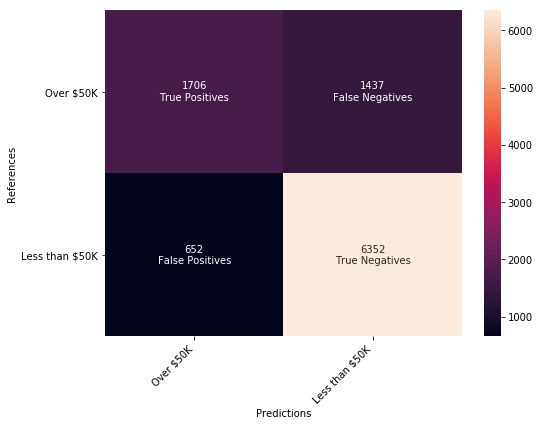

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Precision 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 0.7235 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Recall 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 0.5428 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 False Positive Rate 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 0.0931 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 False Omission Rate 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 0.1845 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
#@title Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Male" #@param {type:"string"}

# Given define subgroup, generate predictions and obtain its corresponding 
# ground truth.
predictions_dict = single_task_deep_model.predict(input_fn=csv_to_pandas_input_fn(
    test_df.loc[test_df[CATEGORY] == SUBGROUP], num_epochs=1, shuffle=False))
predictions = []
for prediction_item, in zip(predictions_dict):
    predictions.append(prediction_item['class_ids'][0])
actuals = list(
    test_df.loc[test_df[CATEGORY] == SUBGROUP]['income_bracket'].apply(
        lambda x: '>50K' in x).astype(int))
classes = ['Over $50K', 'Less than $50K']

# To stay consistent, we have to flip the confusion 
# matrix around on both axes because sklearn's confusion matrix module by
# default is rotated.
rotated_confusion_matrix = np.fliplr(confusion_matrix(actuals, predictions))
rotated_confusion_matrix = np.flipud(rotated_confusion_matrix)

tb = widgets.TabBar(['Confusion Matrix', 'Evaluation Metrics'], location='top')

with tb.output_to('Confusion Matrix'):
  plot_confusion_matrix(rotated_confusion_matrix, classes);

with tb.output_to('Evaluation Metrics'):
  grid = widgets.Grid(2,4)

  p, r, fpr, fomr = compute_eval_metrics(actuals, predictions)

  with grid.output_to(0, 0):
    print " Precision "
  with grid.output_to(1, 0):
    print " %.4f " % p

  with grid.output_to(0, 1):
    print " Recall "
  with grid.output_to(1, 1):
    print " %.4f " % r

  with grid.output_to(0, 2):
    print " False Positive Rate "
  with grid.output_to(1, 2):
    print " %.4f " % fpr

  with grid.output_to(0, 3):
    print " False Omission Rate "
  with grid.output_to(1, 3):
    print " %.4f " % fomr

### Solution

Click below for some insights we uncovered

Using default model parameters, you may find that the model performs better for male than female. Specifically, in our run, we found that both precision and recall for male (0.7490 and 0.4795, respectively) outperformed female (0.6787 and 0.3716, respectively).

Hopefully going through this confusion matrix demonstration you find that the results varies slightly from the overall performance metrics, highlighting the importance of evaluating model performance across subgroup rather than in aggregate.

In your work, make sure that you make a good decision about the tradeoffs between false positives, false negatives, true positives, and true negatives. For example, you may want a very low false positive rate, but a high true positive rate. Or you may want a high precision, but a low recall is okay.  

**Choose your evaluation metrics in light of these desired tradeoffs.**